In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load and prepare data
data = pd.read_csv("ner_dataset.csv", encoding="latin1").ffill()
words = list(data["Word"].unique())
tags = list(data["Tag"].unique())

if "ENDPAD" not in words:
    words.append("ENDPAD")

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

In [4]:
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 19470
Unique tags in corpus: 17


In [6]:
print("Unique tags are:", tags)

Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [7]:
# Group words by sentences
class SentenceGetter:
    def __init__(self, data):
        self.grouped = data.groupby("Sentence #", group_keys=False).apply(
            lambda s: [(w, t) for w, t in zip(s["Word"], s["Tag"])]
        )
        self.sentences = list(self.grouped)

getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[35]

[('The', 'O'),
 ('U.S.', 'B-org'),
 ('Geological', 'I-org'),
 ('Survey', 'I-org'),
 ('gave', 'O'),
 ('a', 'O'),
 ('preliminary', 'O'),
 ('estimate', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('strength', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('Tuesday', 'B-tim'),
 ('morning', 'I-tim'),
 ('quake', 'O'),
 ('at', 'O'),
 ('6.7', 'O'),
 ('on', 'O'),
 ('the', 'O'),
 ('Richter', 'B-geo'),
 ('scale', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('said', 'O'),
 ('the', 'O'),
 ('epicenter', 'O'),
 ('was', 'O'),
 ('close', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 ('of', 'O'),
 ('Nias', 'B-org'),
 ('.', 'O')]

In [9]:
# Encode sentences
X = [[word2idx[w] for w, t in s] for s in sentences]
y = [[tag2idx[t] for w, t in s] for s in sentences]

In [10]:
word2idx

{'Thousands': 1,
 'of': 2,
 'demonstrators': 3,
 'have': 4,
 'marched': 5,
 'through': 6,
 'London': 7,
 'to': 8,
 'protest': 9,
 'the': 10,
 'war': 11,
 'in': 12,
 'Iraq': 13,
 'and': 14,
 'demand': 15,
 'withdrawal': 16,
 'British': 17,
 'troops': 18,
 'from': 19,
 'that': 20,
 'country': 21,
 '.': 22,
 'Families': 23,
 'soldiers': 24,
 'killed': 25,
 'conflict': 26,
 'joined': 27,
 'protesters': 28,
 'who': 29,
 'carried': 30,
 'banners': 31,
 'with': 32,
 'such': 33,
 'slogans': 34,
 'as': 35,
 '"': 36,
 'Bush': 37,
 'Number': 38,
 'One': 39,
 'Terrorist': 40,
 'Stop': 41,
 'Bombings': 42,
 'They': 43,
 'Houses': 44,
 'Parliament': 45,
 'a': 46,
 'rally': 47,
 'Hyde': 48,
 'Park': 49,
 'Police': 50,
 'put': 51,
 'number': 52,
 'marchers': 53,
 'at': 54,
 '10,000': 55,
 'while': 56,
 'organizers': 57,
 'claimed': 58,
 'it': 59,
 'was': 60,
 '1,00,000': 61,
 'The': 62,
 'comes': 63,
 'on': 64,
 'eve': 65,
 'annual': 66,
 'conference': 67,
 'Britain': 68,
 "'s": 69,
 'ruling': 70,
 'L

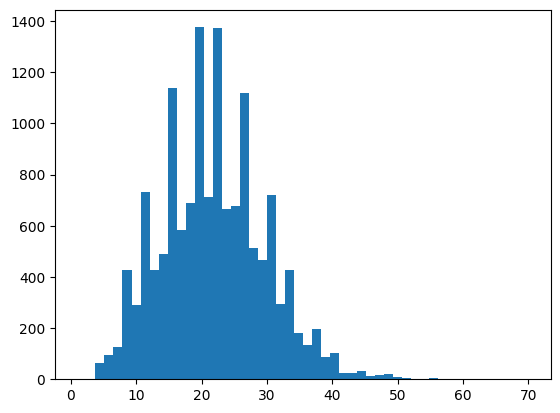

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
# Pad sequences
max_len = 50
X_pad = pad_sequence([torch.tensor(seq) for seq in X], batch_first=True, padding_value=word2idx["ENDPAD"])
y_pad = pad_sequence([torch.tensor(seq) for seq in y], batch_first=True, padding_value=tag2idx["O"])
X_pad = X_pad[:, :max_len]
y_pad = y_pad[:, :max_len]

In [13]:
X_pad[0]

tensor([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
           11,    12,    13,    14,    15,    10,    16,     2,    17,    18,
           19,    20,    21,    22, 19471, 19471, 19471, 19471, 19471, 19471,
        19471, 19471, 19471, 19471, 19471, 19471, 19471, 19471, 19471, 19471,
        19471, 19471, 19471, 19471, 19471, 19471, 19471, 19471, 19471, 19471])

In [14]:
y_pad[0]

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [15]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=1)

In [16]:
# Dataset class
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            "input_ids": self.X[idx],
            "labels": self.y[idx]
        }

train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=32)

In [17]:
class BiLSTMTagger(nn.Module):
  def __init__(self, vocab_size, target_size, embedding_dim=50, hidden_dim=100):
    super(BiLSTMTagger, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout = nn.Dropout(0.1)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_dim*2, target_size)

  def forward(self, x):
    x=self.embedding(x)
    x=self.dropout(x)
    x,_=self.lstm(x)
    return self.fc(x)

In [18]:
model=BiLSTMTagger(len(word2idx)+1, len(tag2idx)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = loss_fn(outputs.view(-1, len(tag2idx)), labels.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids)
                loss = loss_fn(outputs.view(-1, len(tag2idx)), labels.view(-1))

                val_loss += loss.item()

        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Val Loss = {val_loss:.4f}")

    return train_losses, val_losses


In [20]:
def evaluate_model(model, test_loader, X_test, y_test):
    model.eval()
    true_tags, pred_tags = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=-1)
            for i in range(len(labels)):
                for j in range(len(labels[i])):
                    if labels[i][j] != tag2idx["O"]:
                        true_tags.append(idx2tag[labels[i][j].item()])
                        pred_tags.append(idx2tag[preds[i][j].item()])

In [21]:
# Run training and evaluation
train_losses, val_losses = train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=3)
evaluate_model(model, test_loader, X_test, y_test)

Epoch 1: Train Loss = 129.4143, Val Loss = 19.4205
Epoch 2: Train Loss = 63.5616, Val Loss = 12.7351
Epoch 3: Train Loss = 45.4834, Val Loss = 10.0846


Name: Gumma Dileep Kumar
Register Number:212222240032


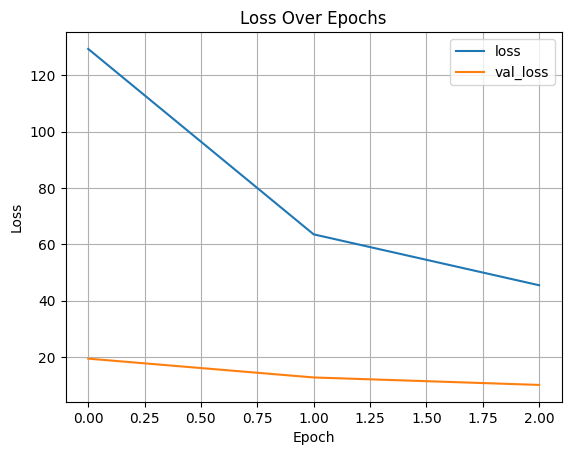

In [22]:
print('Name: Gumma Dileep Kumar')
print('Register Number:212222240032')
history_df = pd.DataFrame({"loss": train_losses, "val_loss": val_losses})
history_df.plot(title="Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [23]:
# Inference and prediction
i = 125
model.eval()
sample = X_test[i].unsqueeze(0).to(device)
output = model(sample)
preds = torch.argmax(output, dim=-1).squeeze().cpu().numpy()
true = y_test[i].numpy()

print('Name: Gumma Dileep Kumar')
print('Register Number:212222240032')
print("{:<15} {:<10} {}\n{}".format("Word", "True", "Pred", "-" * 40))
for w_id, true_tag, pred_tag in zip(X_test[i], y_test[i], preds):
    if w_id.item() != word2idx["ENDPAD"]:
        word = words[w_id.item() - 1]
        true_label = tags[true_tag.item()]
        pred_label = tags[pred_tag]
        print(f"{word:<15} {true_label:<10} {pred_label}")

Name: Gumma Dileep Kumar
Register Number:212222240032
Word            True       Pred
----------------------------------------
Representatives O          O
from            O          O
75              O          O
member          O          O
countries       O          O
will            O          O
debate          O          O
the             O          O
issue           O          O
during          O          O
their           O          O
annual          O          O
meeting         O          O
,               O          O
which           O          O
ends            O          O
Thursday        B-tim      B-tim
.               O          O
